<a href="https://colab.research.google.com/github/edenau/Machine-Learning-Climate-Parameterization/blob/master/main/stage-1/colab/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
# Import libraries

import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
from math import floor, ceil
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import tensorflow as tf
print('All packages imported.')

All packages imported.


In [2]:
# Mount Google Drive locally

from google.colab import drive
drive.mount('/content/gdrive')

# Check data list
!ls '/content/gdrive/My Drive/Colab Notebooks/Parameterization/data/stage-1_cleaned'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
twparmbeatmC1.csv  twparmbeatmC1_no_nan.csv


In [61]:
# Read data

DIR = '/content/gdrive/My Drive/Colab Notebooks/Parameterization/data/stage-1_cleaned/'
f = DIR + 'twparmbeatmC1_no_nan.csv'
df = pd.read_csv(f,index_col=0) # the first column in .csv is index

df = df.drop(columns=['time', 'hour', 'month'])

# Double check NaN does not exist
print('There are {} NaN in the data.'.format(df.isnull().sum().sum()))
df = shuffle(df) # shuffle
df.shape

There are 0 NaN in the data.


(4808, 154)

In [62]:
# Spot faulty data

t_low, t_up = 295, 305
ratio = np.logical_or((df['T_p1000'] < t_low), (df['T_p1000'] > t_up)).sum() / df['T_p1000'].size
print('{:.2f}% of data is faulty.'.format(ratio*100))

0.69% of data is faulty.


In [63]:
#good_data = np.logical_and((df['T_p1000'] >= t_low), (df['T_p1000'] <= t_up))
#df_good = df[good_data]
df_good = df
df_good.shape

(4808, 154)

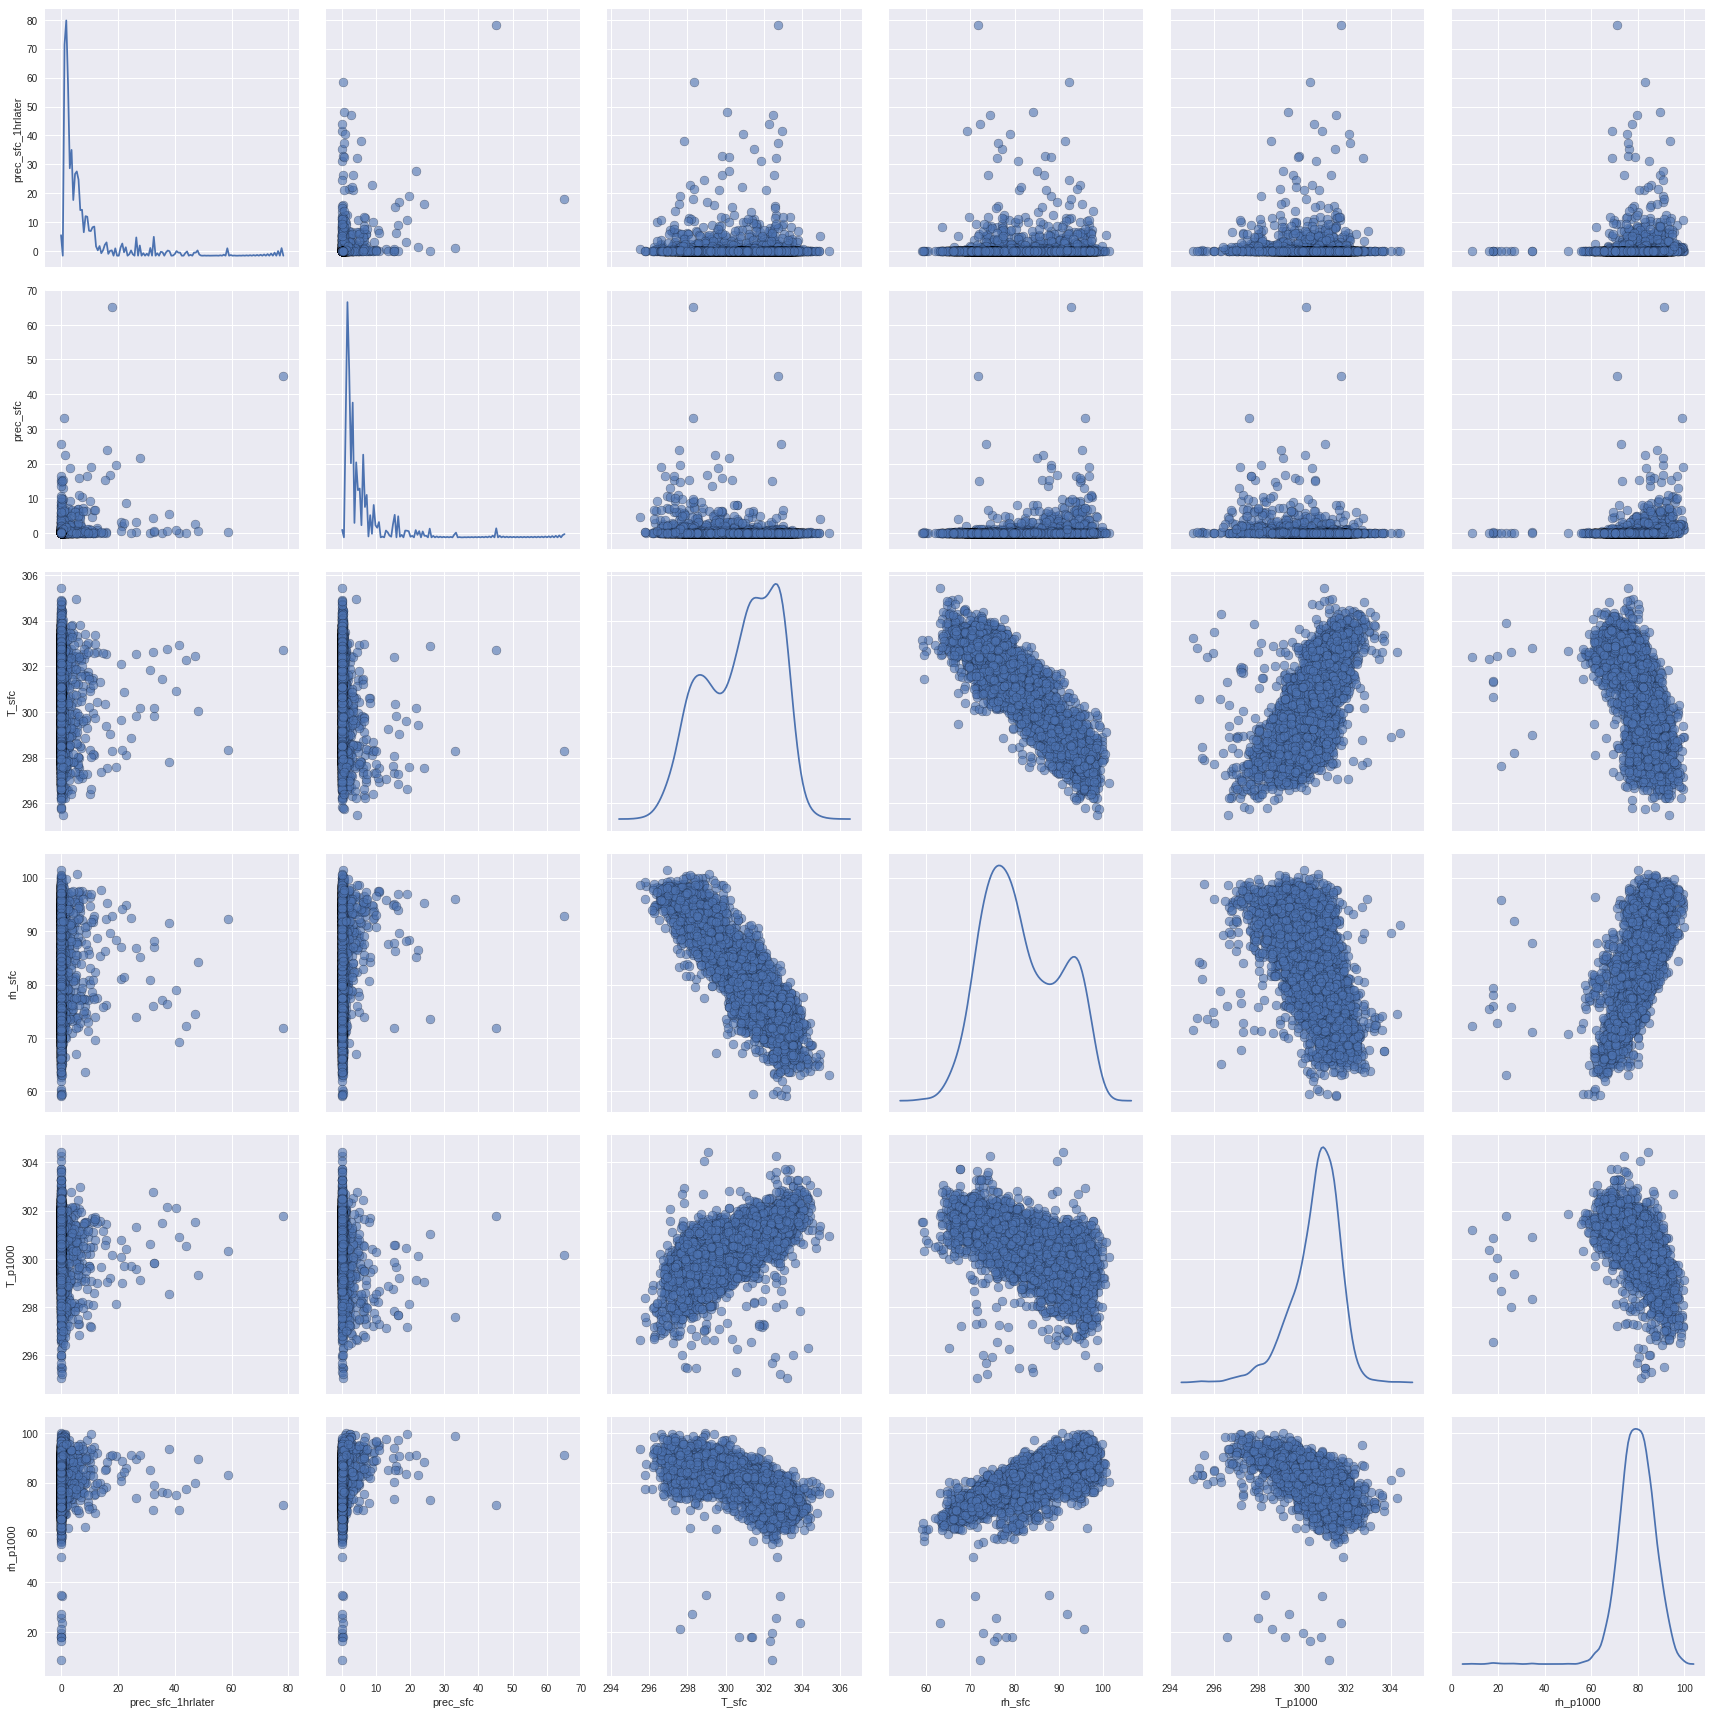

In [49]:
# Pair plot

sns_plot = sns.pairplot(df_good,
                        vars = ['prec_sfc_1hrlater', 'prec_sfc', 'T_sfc', 'rh_sfc', 'T_p1000', 'rh_p1000'],
                        #hue = 'month',
                        palette = 'bright',
                        diag_kind = 'kde',
                        plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'},
                        size = 4)
plt.show()

In [64]:
# Generate inputs and labels

input = df_good.drop(columns='prec_sfc_1hrlater')
raw_label = df_good['prec_sfc_1hrlater']


label = (raw_label.values > 0) # ensure it is in int type # or set 0.1
print('Rainy period ratio= {:.4f}'.format(label.sum()/label.size))

Rainy period ratio= 0.4892


In [65]:
# Split data, deep copy to prevent contaminating raw data with standardization

train_size = 0.6
train_cnt = floor(input.shape[0] * train_size)

x_train = input.iloc[0:train_cnt].copy().values
y_train = label[0:train_cnt].copy()#.reshape([-1,1])
x_test = input.iloc[train_cnt:].copy().values
y_test = label[train_cnt:].copy().reshape([-1,1])

# No need to normalize data for random forests
'''
# Normalize data
INPUT_PRE_NORM = tf.placeholder("float", [None, None], name='pre_norm')
mean, variance = tf.nn.moments(INPUT_PRE_NORM, [0], name='moments') # batch normalization
std = tf.sqrt(variance)

NORM_MEAN = tf.placeholder("float", [None])
NORM_STD = tf.placeholder("float", [None])
normalized = (INPUT_PRE_NORM - NORM_MEAN) / NORM_STD
with tf.Session() as sess:
  # Normalize everything using mean/std of training data
  _mean, _std = sess.run([mean, std], feed_dict = {INPUT_PRE_NORM: x_train})
  x_train = sess.run(normalized, feed_dict = {INPUT_PRE_NORM: x_train,
                                              NORM_MEAN: _mean,
                                              NORM_STD: _std})
  # Double check _mean_0, _std_1 are all zeros and ones
  #_mean_0, _std_1 = sess.run([mean, std], feed_dict = {INPUT_PRE_NORM: x_train})
  #print(_mean_0, _std_1)

  x_test = sess.run(normalized, feed_dict = {INPUT_PRE_NORM: x_test,
                                             NORM_MEAN: _mean,
                                             NORM_STD: _std})

  # No normalization for labels
'''

'\n# Normalize data\nINPUT_PRE_NORM = tf.placeholder("float", [None, None], name=\'pre_norm\')\nmean, variance = tf.nn.moments(INPUT_PRE_NORM, [0], name=\'moments\') # batch normalization\nstd = tf.sqrt(variance)\n\nNORM_MEAN = tf.placeholder("float", [None])\nNORM_STD = tf.placeholder("float", [None])\nnormalized = (INPUT_PRE_NORM - NORM_MEAN) / NORM_STD\nwith tf.Session() as sess:\n  # Normalize everything using mean/std of training data\n  _mean, _std = sess.run([mean, std], feed_dict = {INPUT_PRE_NORM: x_train})\n  x_train = sess.run(normalized, feed_dict = {INPUT_PRE_NORM: x_train,\n                                              NORM_MEAN: _mean,\n                                              NORM_STD: _std})\n  # Double check _mean_0, _std_1 are all zeros and ones\n  #_mean_0, _std_1 = sess.run([mean, std], feed_dict = {INPUT_PRE_NORM: x_train})\n  #print(_mean_0, _std_1)\n\n  x_test = sess.run(normalized, feed_dict = {INPUT_PRE_NORM: x_test,\n                                     

In [66]:
# Build Random Forest

for num_tree in [1000]:
  clf = RandomForestClassifier(n_estimators=num_tree)
  clf = clf.fit(x_train, y_train)

  # Predict and calculate accuracy
  pred = clf.predict(x_test).reshape([-1,1])
  with tf.Session() as sess:
    PRED = tf.placeholder(tf.int32, [None,1])
    LABEL = tf.placeholder(tf.int32, [None,1])
    same = tf.equal(PRED, LABEL)
    accuracy = tf.reduce_mean(tf.cast(same, tf.float32))
  
    _accuracy = sess.run(accuracy, feed_dict={PRED: pred, LABEL: y_test})

  print('#tree= {}, test accuracy= {:.4f}'.format(num_tree, _accuracy))

#tree= 1000, test accuracy= 0.8534


Predicted number of rainy hours= 853, total hours= 1924


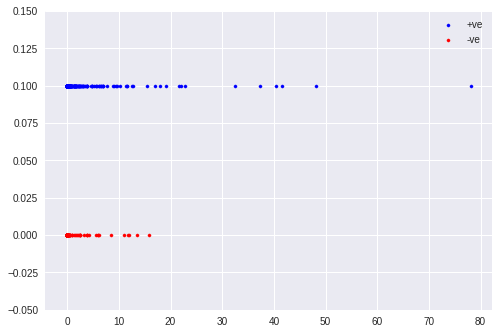

In [68]:
# Plot
test_raw_label = raw_label[train_cnt:].values
rainy = pred == 1
print('Predicted number of rainy hours= {}, total hours= {}'.format(rainy.sum(), rainy.size))
plt.figure()
plt.scatter(test_raw_label[rainy[:,0]], np.zeros(test_raw_label[rainy[:,0]].size) + .1, c='blue', label='+ve', s=10)
plt.scatter(test_raw_label[~rainy[:,0]], np.zeros(test_raw_label[~rainy[:,0]].size), c='red', label='-ve', s=10)
axes = plt.gca()
#axes.set_xlim([0,.01])
axes.set_ylim([-.05,.15])
axes.legend()

plt.show()


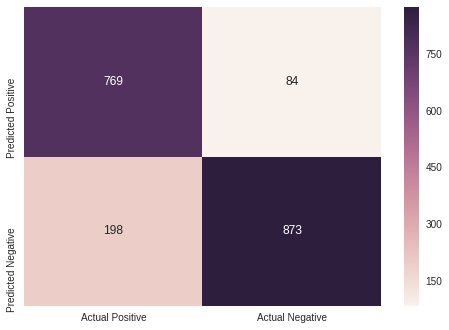

In [69]:
# Confusion matrix
conf = [[np.logical_and(pred, y_test).sum(), np.logical_and(pred, np.logical_not(y_test)).sum()],
        [np.logical_and(np.logical_not(pred), y_test).sum(), np.logical_and(np.logical_not(pred), np.logical_not(y_test)).sum()]] # [TP,FP],[FN,TN]
df_conf = pd.DataFrame(conf, index = [i for i in ['Predicted Positive','Predicted Negative']], columns = [i for i in ['Actual Positive','Actual Negative']])

plt.figure()
sb.heatmap(df_conf, annot=True, fmt='.0f')

plt.show()